In this blog post, we're going to take a look at vocal folds. There are a lot of good videos of vocal folds in action. However, they only show one part of the story. I want to take the opportunity and add an extra element of visualization to a video found on the internet: a spectrogram. 

If you're only interested in the result, here is what we will end up with:

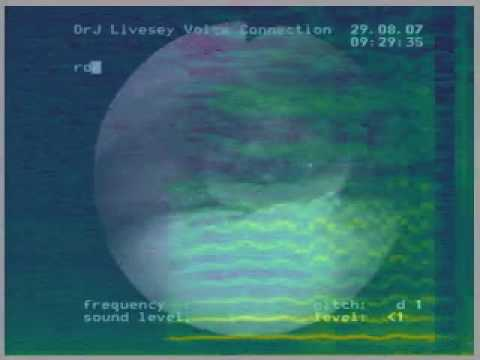

In [27]:
YouTubeVideo('VSgafsbA6Wg')

# Finding a good vocal folds video 

The first step is to find a good vocal folds video. I've been searching a little bit and it turns out there is one that got my attention:

In [1]:
from IPython.display import YouTubeVideo

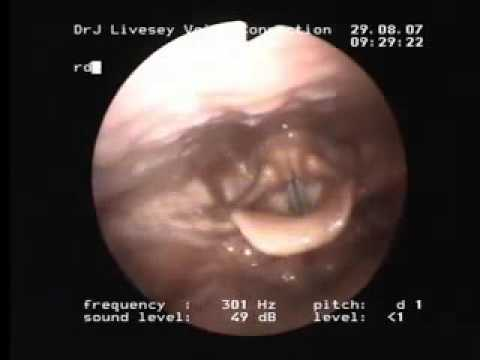

In [2]:
YouTubeVideo('vUF6kvh5GJQ')

Let's use `youtube-dl` and fetch this video to disk:

In [3]:
!youtube-dl vUF6kvh5GJQ

[youtube] vUF6kvh5GJQ: Downloading webpage
[youtube] vUF6kvh5GJQ: Downloading video info webpage
[youtube] vUF6kvh5GJQ: Extracting video information
[youtube] vUF6kvh5GJQ: Downloading MPD manifest
[download] Opera singer Vocal Folds-vUF6kvh5GJQ.mkv has already been downloaded and merged


# Extracting the audio 

Let's now extract some audio information from the video. We'll use the `moviepy` library to do this.

In [4]:
import moviepy.editor as mpy

In [5]:
clip = mpy.VideoFileClip('Opera singer Vocal Folds-vUF6kvh5GJQ.mkv')

Once the clip is loaded, we can access its audio via its `clip.audio` attribute, which is documented here: <https://zulko.github.io/moviepy/ref/AudioClip.html>. What we want is to extract the audio, plot it and superimpose it on the existing video. By accessing the audio clip object, we can the sound data in array format.

In [6]:
sample_rate = clip.audio.fps
audio_data = clip.audio.to_soundarray()

In [7]:
audio_data.shape

(5026518, 2)

The audio data is made of two columns, which makes sense since the audio is stereo. Let's see what the sampling rate is:

In [8]:
sample_rate

44100

This is the classically used 44100 Hz. 

# Visualizing the sound

Let's see what the sound data looks when it's plotted using `matplotlib`. 

In [9]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

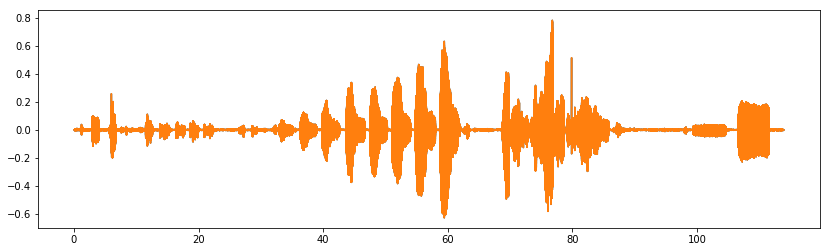

In [10]:
fig, ax = plt.subplots(figsize=(14, 4))
t = np.arange(audio_data.shape[0], dtype=np.float) / sample_rate
ax.plot(t, audio_data)

It's not easy to make out what this actually means. Therefore, let's move on to a spectrogram vizualisation.

In [11]:
NFFT = sample_rate / 25

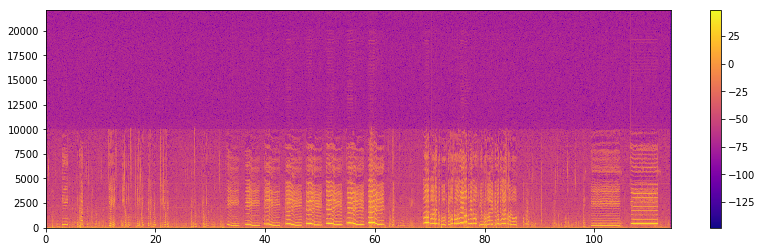

In [12]:
fig, ax = plt.subplots(figsize=(14, 4))
spectrum, freqs, time, im = ax.specgram(audio_data.mean(axis=1), NFFT=NFFT, pad_to=4096, Fs=sample_rate, 
                                        noverlap=512, mode='magnitude', cmap='plasma')
fig.colorbar(im)

This is quite interesting. I guess that the upper frequencies show up as noice. This makes me wonder whether the original sound was recorded at a sample rate of 20 kHz rather than 44.1 kHz. 

Can we use that data and render it on top of the original videoclip?

# Rendering the sound on top of the original video

What we need to do is to layout a matplotlib figure, extract as an image and fuse it with the original video frames. 
Let's start with the [standard moviepy matplotlib example](http://zulko.github.io/moviepy/getting_started/working_with_matplotlib.html) and adjust it to our needs.

First, I define my dpi values (this depends on my screen, I used <https://www.sven.de/dpi/> to determine this value).

In [13]:
my_dpi = 226.98

Now, let's use the same pixel sizes as those of the original clip:

In [14]:
width, height = clip.size
width, height

(320, 240)

We can now generate a short animation, that we will try to superpose with the existing movie:

In [15]:
from moviepy.editor import VideoClip
from moviepy.video.io.bindings import mplfig_to_npimage

x = np.linspace(-2, 2, 200)

duration = 2

fig, ax = plt.subplots(figsize=(width/my_dpi, height/my_dpi), dpi=my_dpi)
def make_frame(t):
    ax.clear()
    ax.plot(x, np.sinc(x**2) + np.sin(x + 2*np.pi/duration * t), lw=3)
    ax.set_ylim(-1.5, 2.5)
    return mplfig_to_npimage(fig)

animation = VideoClip(make_frame, duration=duration)
plt.close(fig)
animation.ipython_display(fps=20, loop=True, autoplay=True)

 98%|█████████▊| 40/41 [00:02<00:00, 15.43it/s]


Let's check the sizes of the generated images:

In [16]:
make_frame(0).shape

(240, 320, 3)

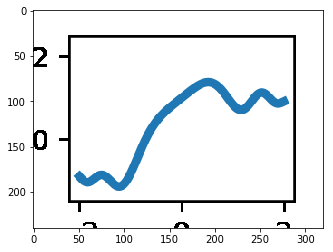

In [17]:
plt.imshow(make_frame(0))

In [18]:
clip.get_frame(0).shape

(240, 320, 3)

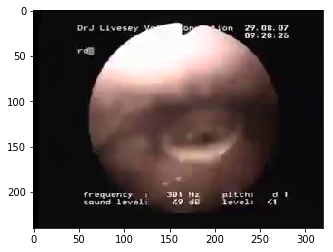

In [19]:
plt.imshow(clip.get_frame(0))

Okay, everything matches, let's try to merge the two clips together.

In [20]:
mask_array = np.ones(clip.size[::-1]) * 0.6

In [21]:
mask = mpy.ImageClip(img=mask_array,ismask=True)

In [22]:
stack = mpy.CompositeVideoClip([clip.subclip(t_start=0, t_end=2), animation.set_mask(mask)], use_bgclip=True)

In [23]:
mpy.ipython_display(stack, loop=True, autoplay=True)

 98%|█████████▊| 50/51 [00:02<00:00, 17.60it/s]


Now that this works, let's do the final video: 

In [24]:
fig, ax = plt.subplots(figsize=(width/my_dpi, height/my_dpi), dpi=my_dpi, )
selection = np.abs(0 - time) < 1.
freq_selection = freqs < 10000
ax.pcolorfast(time[selection], freqs, 20 * np.log10(spectrum[:, selection]))
ax.set_xticklabels([])
ax.set_yticklabels([])
plt.tight_layout(pad=0)
def make_specgram(t):
    ax.clear()
    selection = np.abs(t - time) < 1.
    ax.pcolorfast(time[selection], freqs[freq_selection], 20 * np.log10(spectrum[freq_selection, :][:, selection]))
    ax.axis('off')
    ax.set_frame_on(False)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    return mplfig_to_npimage(fig)

specgram_animation = VideoClip(make_specgram).set_duration(clip.duration).set_audio(clip.audio)
plt.close(fig)

stack = mpy.CompositeVideoClip([clip, specgram_animation.set_mask(mask)], use_bgclip=True)
stack.subclip(t_start=30, t_end=90).write_videofile('output.mp4')

[MoviePy] >>>> Building video output.mp4
[MoviePy] Writing audio in outputTEMP_MPY_wvf_snd.mp3


100%|██████████| 1323/1323 [00:01<00:00, 995.20it/s] 

[MoviePy] Done.
[MoviePy] Writing video output.mp4



100%|█████████▉| 1500/1501 [02:47<00:00,  9.31it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output.mp4 



I've uploaded the output to YouTube, which you can see below:

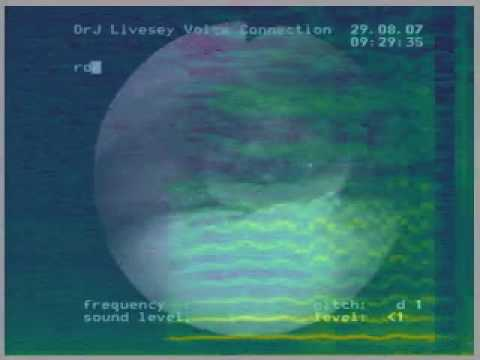

In [26]:
YouTubeVideo('VSgafsbA6Wg')

# Conclusions 

In this blog post, we managed to plot a spectrogram on top of an existing clip of vocal folds. This opens interesting perspectives for trying to understand this complex part of the singing process. To achieve that, we leveraged the power of the matplotlib and moviepy libraries in a relatively straightforward fashion and finally used YouTube to broadcast the result.
It could be fun to program a YouTube bot that could do this automatically and annotate existing vocal folds videos like these.